In [1]:
import os
import sys
sys.path.append('../python')

import pandas as pd
import numpy as np
import yaml
import time
import json
import ast

from sklearn.decomposition import PCA

from matplotlib import pyplot as plt

import api
import data_tools
import text_tools

namespace = 'la_planning_dept_cases'

In [ ]:
df.loc[ df['Requested Entitlement']=='0']

In [2]:
df = data_tools.get_la_planning_dept_cases()
texts = list(df['text'])

In [3]:
%time embeddings = api.get_embeddings(texts, namespace=namespace)

Records retrieved from Pinecone: 6587
Records processed by OpenAI: 0
Pinecone Read Units: 669


In [6]:
X = np.array(embeddings)

In [7]:
pca = PCA(n_components=2)

In [9]:
X_pca = pca.fit_transform(X)
df['x'] = X_pca[:,0]
df['y'] = X_pca[:,1]

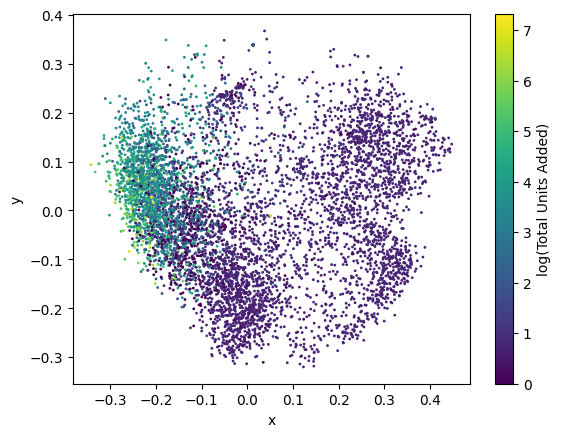

In [182]:
c = np.log(1+df['Total Adding'])
alpha = 0.1 + 0.9*(c - c.min())/(c.max() - c.min())
plt.scatter(x=X_pca[:,0], y=X_pca[:,1], c=c, s=1)
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar(label='log(Total Units Added)')
plt.show()

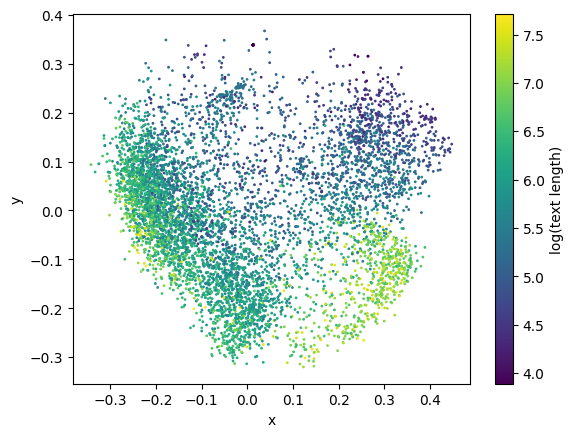

In [151]:
plt.scatter(x=X_pca[:,0], y=X_pca[:,1], c=np.log(df['text'].str.len()), s=1)
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar(label='log(text length)')
plt.show()

In [153]:
df['Days to Complete'] = (df['Completion Date'] - df['Filed Date'])/pd.to_timedelta(1,unit='D')

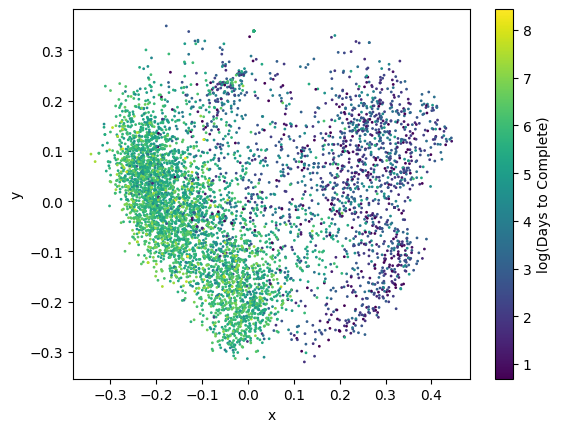

In [158]:
idx = df['Days to Complete']>0
plt.scatter(x=X_pca[idx,0], y=X_pca[idx,1], c=np.log(1+df.loc[idx,'Days to Complete']), s=1)
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar(label='log(Days to Complete)')
plt.show()

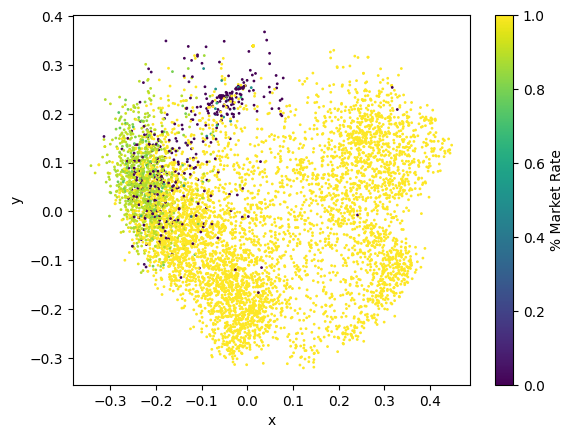

In [179]:
plt.scatter(x=X_pca[:,0], y=X_pca[:,1], c=1-df['% Affordable Adding'], s=1)
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar(label='% Market Rate')
plt.show()

In [200]:
idx = (df['x']<-0.1) & (df['y']<-0.1)
print(df.loc[idx].sample(1).iloc[0]['text'])

Project Description:
1. A VESTING ZONE CHANGE FROM[Q]P-1VL-ZONED PORTION OF THE SUBJECT PROPERTY TO C2-1VL;
2. BUILDING LINE REMOVAL OF THE 15-FOOT BUILDING LINE LOCATED ALONG MOORPARK STREET, ESTABLISHED BY ORDINANCE 97,921;
3. A CONDITIONAL USE PERMIT, TO OPERATE BETWEEN THE HOURS OF 11 P.M. AND 7 A.M. DAILY FOR 24-HOUR GROCERY STORE OPERATION;
4. A CONDITIONAL USE BEVERAGE, FOR THE SALE OF A FULL LINE OF ALCOHOLIC BEVERAGES FOR ON-SITE INSTRUCTIONAL TASTINGS AND OFF-SITE CONSUMPTION IN CONJUNCTION WITH A GROCERY STORE, AND THE SALE OF A FULL LINE OF ALCOHOLIC BEVERAGES FOR ON-SITE CONSUMPTION IN CONJUNCTION WITH THE OPERATION OF A RESTAURANT;
5. SPECIFIC PLAN EXCEPTION, FROM THE VENTURA/CAHUENGA BOULEVARD CORRIDOR SPECIFIC PLAN:
TO PERMIT A MAXIMUM HEIGHT OF APPROXIMATELY 38 FEET-10INCHES IN LIEU OF THE 30-FOOT MAXIMUM HEIGHT PERMITTED;
6. A PROJECT PERMIT COMPLIANCE REVIEW, PURSUANT TO LAMC SECTION 11.5.7-C., FOR THE PROPOSED PROJECT UNDER THE VENTURA/CAHUENGA BOULEVARD CORRIDOR SP